(40000,)
320
(40000,)
289
(40000,)
290
(40000,)
275
(40000,)
297
[-8.992347  -7.6159554 -1.4564008 ...  4.428571   1.6562009  3.7755103]
[-8.367347  -7.16141   -1.0018553 ...  4.7619047  2.0408163  3.9929016]


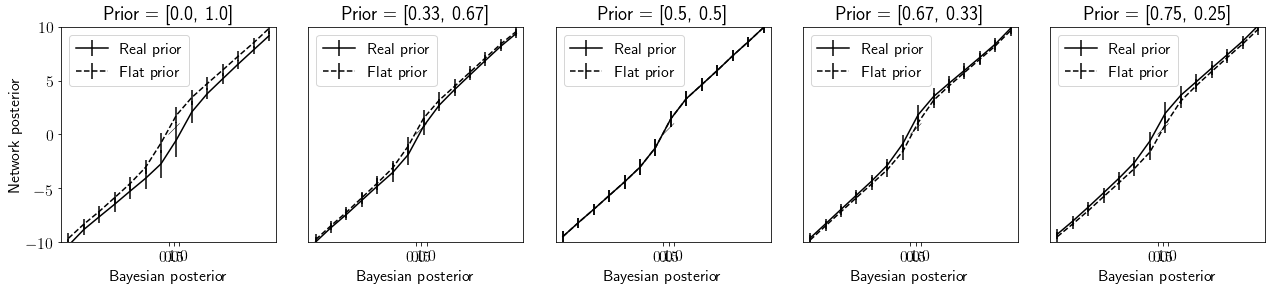

In [11]:
import sys
sys.path.append("/home/squax/GitHub/PNN/")
import torch
import numpy as np
import tqdm
import json

import matplotlib.pyplot as plt
import scipy.stats as sst

from tasks import *
from pytorch_networks import *
from tools import *
from pytorch_trainer import *

plt.rcParams.update({'font.size': 16})
# # model parameters
# N_input = 50
# N_hidden = 200

# # task parameters
# N_test = 20000
# N_class = 1
# N_cond = 2
# means=[-5, 5]
# sigmas=[9, 9]
# gain=np.array([0.37,0.90,1.81,2.82,3.57,4.00])*0.4 #*0.4
# prior=[0.75,0.25]

# model location
predictors = []
Qs = []
priors = []
tests = []

for task_id in xrange(1,6):
    task = 'class_'+str(task_id)
    
    param_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/param_GNH200_est' + task + ''#2
    model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model_GNH200_est' + task + ''#2
#     if task_id ==2:
#         param_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/param10_' + task + '_2'#2
#         model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model10_' + task + '_2'#2
    with open(param_loc+'.json','r') as fp:
        params = json.load(fp)   
    locals().update(params)
    N_test = 20000

    priors.append(prior)
    # define task
    test_data = continuous_class_task(mu=means,sig2=sigmas,n_samples=N_test, sig2N = sig_phi,g=gain, n_input=N_input, pCin=prior,test=True,original=False)

    # define iterator
    test_iter = FixedIterator(test_data, batch_size=N_test*len(gain)*N_class*N_cond)

    # define model
    model = Regressor(MLP(N_input,N_hidden, 1, bias = False))

    # setup optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)


    # load model
    model.load_state_dict(torch.load(model_loc))
    model.eval()
    
    #model.predictor.l2.b.data[[0,1]]=model.predictor.l2.b.data[[1,0]]
#     model = Classifier(model)
    # setup tester
    test = tester(model)

    # run tester
    test.run(test_iter)
    
    predictors.append(model.predictor)
    tests.append(test)

    # extract relevant data
    Q = extract_quantities(test,gain,N_test,2)
    print(np.sum(test.R,1)[np.squeeze(test.G==gain[0])].shape)
    print(len(test.R)/6-np.count_nonzero(np.sum(test.R,1)[np.squeeze(test.G==gain[0])]))

    Qs.append(Q)
    HP11=bin_plot(test.real_posterior[:],test.test_posterior[:,0],bin_lim = [-10,10])
    HP21=bin_plot(test.real_posterior2[:],test.test_posterior[:,0],bin_lim=[-10,10])

    plt.figure(1,figsize = (18,4))
    plt.subplot(1,5,task_id)
    plt.errorbar(HP11['bins'],HP11['post_mean'],HP11['post_std'],fmt='k',label ='Real prior')
    plt.errorbar(HP21['bins'],HP21['post_mean'],HP21['post_std'],fmt='k--', label = 'Flat prior')
    plt.plot([0,1],[0,1],'k',linewidth=0.5)
    ax=plt.gca()
    ax.set_aspect(1)
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.title('Prior = '+str(prior))
    plt.xlabel('Bayesian posterior')
    plt.xticks([0,0.5,1])
    plt.legend()
    if task_id == 1:
        plt.ylabel('Network posterior')
    else:
        plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/real_vs_flat3.eps',format='eps')
print(test.real_posterior[:])
print(test.real_posterior2[:])


114
86
113
87
100
100
101
99
74
126


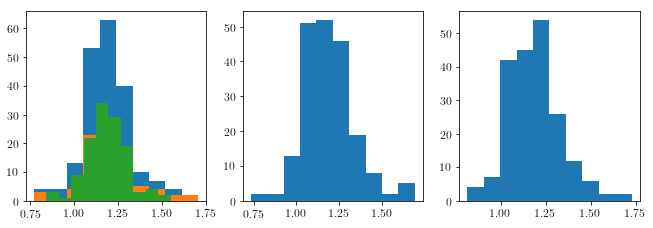

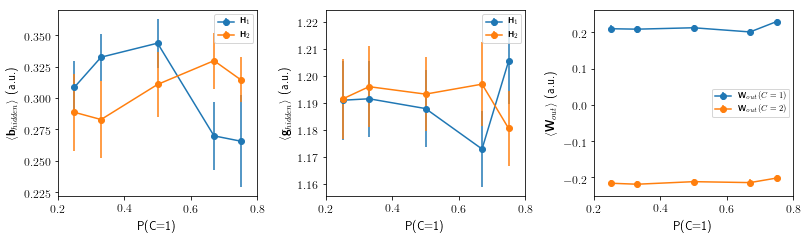

In [21]:
import scipy.stats as sst

from matplotlib import rc

# activate latex text rendering
rc('text', usetex=True)

plt.rcParams.update({'font.size': 12})

b2 = np.zeros((5,200))
s2 = np.zeros((5,200))

W_out_all = np.zeros((5,2))
b_hid_all = np.zeros((5,2))
W_hid_all = np.zeros((5,2))
W_out_std = np.zeros((5,2))
b_hid_std = np.zeros((5,2))
W_hid_std = np.zeros((5,2))
s_hid_all = np.zeros((5,2))
s_hid_std = np.zeros((5,2))
N_all = np.zeros((5,2))


x = np.array([0.25,0.33,0.5,0.67,0.75])
for task_id in xrange(0,5):

    W = predictors[task_id].l1.weight.data.numpy()
    W2 = predictors[task_id].l2.weight.data.numpy()
    b = predictors[task_id].l1.bias.data.numpy()
    b2[task_id,:] = predictors[task_id].l1.bias.data.numpy()

    s = predictors[task_id].p1.data.numpy()
    s2[task_id,:] = predictors[task_id].p1.data.numpy()
    #b2 = model.predictor.l2.b.data

    idx = np.where(W2[0,:]>0.0)
    idx2 = np.where(W2[0,:]<0.0)
    print(len(idx[0]))
    print(len(idx2[0]))
    N_all[task_id,0] = len(idx[0][:])
    N_all[task_id,1] = len(idx2[0][:])

    W_hid_all[task_id,0] = np.mean(W[idx,:].flatten())
    W_hid_all[task_id,1] = np.mean(W[idx2,:].flatten())
    W_out_all[task_id,0] = np.mean(W2[0,idx].flatten())
    W_out_all[task_id,1] = np.mean(W2[0,idx2].flatten())
    b_hid_all[task_id,0] = np.mean(b[idx].flatten())
    b_hid_all[task_id,1] = np.mean(b[idx2].flatten())
    s_hid_all[task_id,0] = np.mean(s[idx].flatten())
    s_hid_all[task_id,1] = np.mean(s[idx2].flatten())
    
    W_hid_std[task_id,0] = np.std(W[idx,:].flatten())/np.sqrt(len(idx[0]))
    W_hid_std[task_id,1] = np.std(W[idx2,:].flatten())/np.sqrt(len(idx2[0]))
    W_out_std[task_id,0] = np.std(W2[0,idx].flatten())/np.sqrt(W2.shape[1])
    W_out_std[task_id,1] = np.std(W2[0,idx2].flatten())/np.sqrt(W2.shape[1])
    b_hid_std[task_id,0] = np.std(b[idx].flatten())/np.sqrt(len(idx[0]))
    b_hid_std[task_id,1] = np.std(b[idx2].flatten())/np.sqrt(len(idx2[0]))
    s_hid_std[task_id,0] = np.std(s[idx].flatten())/np.sqrt(len(idx[0]))
    s_hid_std[task_id,1] = np.std(s[idx2].flatten())/np.sqrt(len(idx2[0]))

plt.figure(figsize = (11,3.5))
plt.subplot(1,3,1)
# plt.boxplot(b2.T)
plt.hist(s2[2,:].T)
plt.hist(s2[2,idx].T)
plt.hist(s2[2,idx2].T)

plt.subplot(1,3,2)
# plt.boxplot(b2.T)
plt.hist(s2[0,:].T)

plt.subplot(1,3,3)
# plt.boxplot(b2.T)
plt.hist(s2[4,:].T)

plt.figure(figsize = (15,3.5))
plt.subplot(1,4,1)
plt.errorbar(x,b_hid_all[:,0],b_hid_std[:,0],marker='o')
plt.errorbar(x,b_hid_all[:,1],b_hid_std[:,1],marker='o')

plt.xlim(0.2,0.8)
# plt.ylim(0.0,0.18)
# plt.ylim(0.15,0.50)
plt.xlabel('P(C=1)')
# plt.yticks([])
plt.ylabel(r'$\langle \textbf{b}_{hidden} \rangle$ (a.u.)')
# plt.legend([r'$W_{out}(C=1)>W_{out}(C=2)$',r'$W_{out}(C=1)<W_{out}(C=2)$'],prop={'size': 8})
plt.legend([r'$\textbf{H}_1$',r'$\textbf{H}_2$'],prop={'size': 8})

plt.subplot(1,4,3)
plt.errorbar(x,W_out_all[:,0],W_out_std[:,0],marker='o')
plt.errorbar(x,W_out_all[:,1],W_out_std[:,1],marker='o')

plt.xlim(0.2,0.8)
# plt.ylim(-0.05,0.05) 
# plt.yticks([])

plt.xlabel('P(C=1)')
plt.ylabel(r'$\langle \textbf{W}_{out} \rangle$ (a.u.)')
plt.legend([r'$\textbf{W}_{out}(C=1)$',r'$\textbf{W}_{out}(C=2)$'],prop={'size': 8})

# plt.subplot(1,3,2)
# plt.errorbar(x,W_hid_all[:,0],W_hid_std[:,0],marker='o')
# plt.errorbar(x,W_hid_all[:,1],W_hid_std[:,1],marker='o')

# plt.xlim(0.2,0.8)
# plt.ylim(-0.23,0.05)
# # plt.yticks([])

# plt.xlabel('P(C=1)')
# plt.ylabel(r'$\langle W_{hidden} \rangle$ (a.u.)')
# plt.legend([r'$W_{out}(C=1)>W_{out}(C=2)$',r'$W_{out}(C=1)<W_{out}(C=2)$'],prop={'size': 8})
# plt.tight_layout()

plt.subplot(1,4,2)
plt.errorbar(x,s_hid_all[:,0],s_hid_std[:,0],marker='o')
plt.errorbar(x,s_hid_all[:,1],s_hid_std[:,1],marker='o')

plt.xlim(0.2,0.8)
# plt.ylim(0.9,1.07)
# plt.ylim(1.2,1.4)
# plt.yticks([])

plt.xlabel('P(C=1)')
plt.ylabel(r'$\langle \textbf{g}_{hidden} \rangle$ (a.u.)')
# plt.legend([r'$W_{out}(C=1)>W_{out}(C=2)$',r'$W_{out}(C=1)<W_{out}(C=2)$'],prop={'size': 8})
plt.legend([r'$\textbf{H}_1$',r'$\textbf{H}_2$'],prop={'size': 8})

# plt.subplot(1,4,4)
# plt.plot(x,N_all[:,0],marker='o')
# plt.plot(x,N_all[:,1],marker='o')

# plt.xlim(0.2,0.8)
# # plt.ylim(1,1.07)
# plt.ylim(80,120)
# # plt.yticks([])

# plt.xlabel('P(C=1)')
# plt.ylabel(r'$\langle G_{hidden} \rangle$ (a.u.)')
# plt.legend([r'$W_{out}(C=1)>W_{out}(C=2)$',r'$W_{out}(C=1)<W_{out}(C=2)$'],prop={'size': 8})
plt.tight_layout()

# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/bias_gain_new2.eps',format='eps')

# sst.ttest_ind(W2[0,:].flatten(),W2[1,:].flatten())



(5, 6)
(5, 6)
(6, 10)


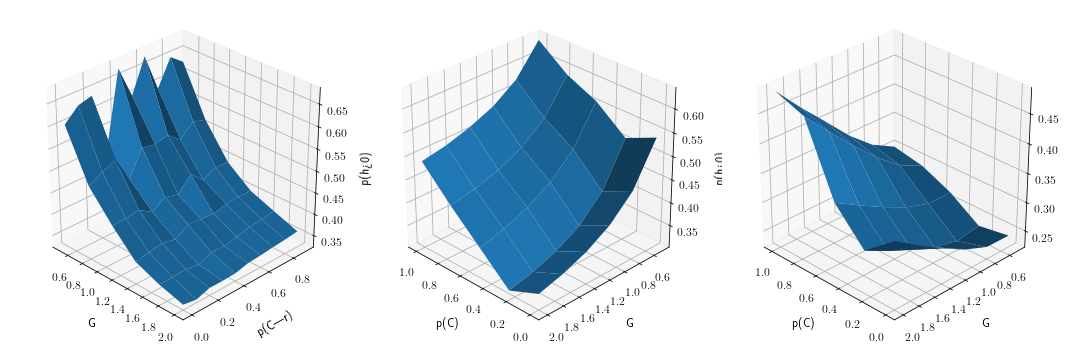

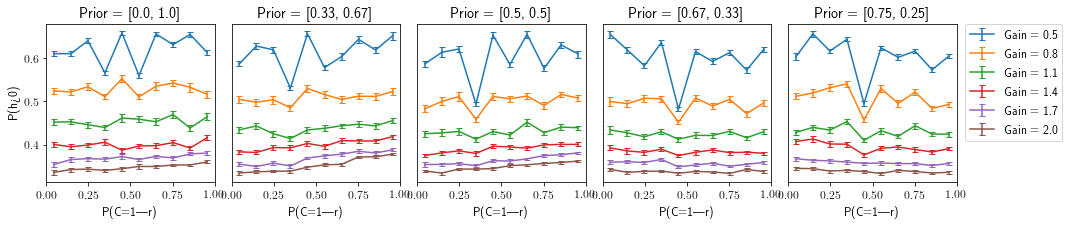

In [13]:
from mpl_toolkits.mplot3d import Axes3D

mean1 = np.zeros((5,6))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(132,projection='3d')
for task_id in xrange(0,5):
    mean1[task_id,:]=np.nanmean(Qs[task_id]['sp_all'][:,:N_test],axis=1)
#     mean2=np.nanmean(Qs[task_id]['sp_all'][:,N_test:])
X = np.arange(0, 1.25,0.25)
Y = gain
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(mean1.shape)
ax.plot_surface(X,Y,mean1.T)
ax.set_xlabel('p(C)')
ax.set_ylabel('G')
ax.set_zlabel('p(h>0)')
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10

ax.view_init(30, 135)
# plt.tight_layout()
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/sparse_prior_vs_gain.eps',format='eps')


mean1 = np.zeros((5,6))

ax = fig.add_subplot(133,projection='3d')
for task_id in xrange(0,5):
    mean1[task_id,:]=np.nanmean(Qs[task_id]['H_mean_all'][:,:N_test],axis=1)
#     mean2=np.nanmean(Qs[task_id]['sp_all'][:,N_test:])
X = np.arange(0, 1.25,0.25)
Y = gain
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(mean1.shape)
ax.plot_surface(X,Y,mean1.T)
ax.set_xlabel('p(C)')
ax.set_ylabel('G')
ax.set_zlabel(r'$\langle r \rangle$')
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10

ax.view_init(30, 135)
plt.tight_layout()
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/sparse_r_prior_vs_gain.eps',format='eps')


mean2 = np.zeros((6,10))

ax = fig.add_subplot(131,projection='3d')

for ii in xrange(len(gain)):
    H = bin_plot(Qs[2]['Pg'][ii], Qs[2]['sp_all'][ii], sem=True, n_bins=11)
    mean2[ii,:]=H['post_mean']
#     mean2=np.nanmean(Qs[task_id]['sp_all'][:,N_test:])
X = gain
Y = np.arange(0, 1,0.1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(mean2.shape)
ax.plot_surface(X,Y,mean2.T)
ax.set_xlabel('G')
ax.set_ylabel('p(C|r)')
ax.set_zlabel('p(h>0)')
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10

ax.view_init(30, 315)
plt.tight_layout()
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/3D_prior_vs_gain2.eps',format='eps')

plt.figure(figsize=(15,3.3))
for task_id in xrange(0,5):
    plt.subplot(151+task_id)
    for ii in xrange(len(gain)):
        H = bin_plot(Qs[task_id]['Pg'][ii], Qs[task_id]['sp_all'][ii], sem=True, n_bins=11)

        plt.errorbar(H['bins'],H['post_mean'],H['post_std'], label=('Gain = '+str(gain[ii])),capsize=3)
#         plt.ylim([0.0,0.3])
        if task_id == 0:
            plt.ylabel('P(h>0)')
        else:
            plt.yticks([])
    plt.xlabel('P(C=1|r)')
    plt.title('Prior = '+str(priors[task_id]))
    
    if task_id == 4:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

[[0.2206726 ]
 [0.07185268]
 [3.2451625 ]
 ...
 [2.498065  ]
 [0.40744925]
 [0.36866665]]
0.7888772
[[0.02950478]
 [0.43677044]
 [0.12617111]
 ...
 [1.2837691 ]
 [0.864382  ]
 [0.4517821 ]]
0.7760825
[[0.39486837]
 [0.00151443]
 [0.80975103]
 ...
 [0.61257553]
 [0.12401438]
 [0.4586177 ]]
0.78165406
[[0.70752525]
 [0.11796713]
 [0.70311785]
 ...
 [0.14442778]
 [0.01537657]
 [0.03957319]]
0.7785079
[[2.822959  ]
 [1.9125357 ]
 [1.5332184 ]
 ...
 [0.06819725]
 [0.02969551]
 [0.12430477]]
0.78290415


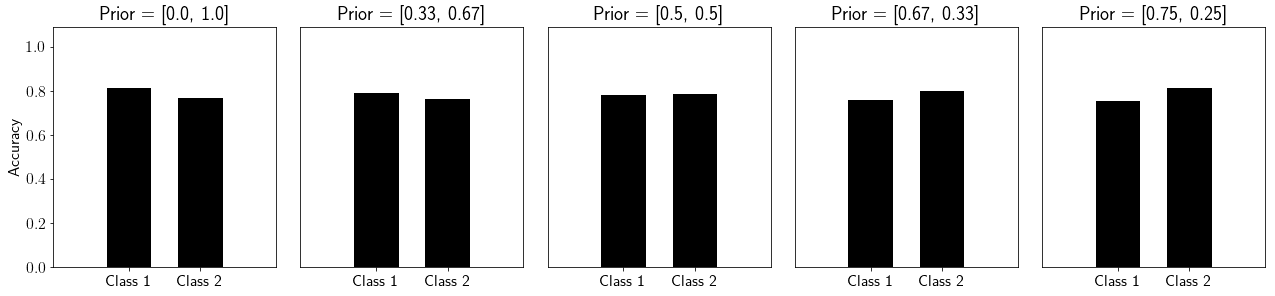

In [24]:
plt.rcParams.update({'font.size': 16})

plt.figure(2, figsize = (18,4.4))
for ii in xrange(5):
    correct = np.sqrt((tests[ii].test_posterior-tests[ii].C)**2)
    print(correct)
    acc1 = np.mean(correct[:len(tests[ii].C)/2])
    acc2 = np.mean(correct[len(tests[ii].C)/2:])
    print(np.mean(correct[:]))
    
    plt.subplot(1,5,ii+1)
    plt.bar([0.7,2.3],[acc1,acc2], width = 1.0, color = 'k')
    plt.xlim([-1,4])
    plt.ylim([0,1.09])

#     plt.xlabel('Class')
    plt.xticks([0.7,2.3],['Class 1','Class 2'])
    if ii == 0:
        plt.ylabel('Accuracy')
    else:
        plt.yticks([])
    plt.title('Prior = '+str(priors[ii]))
    plt.tight_layout()
#     plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/Error_vs_prior.eps',format='eps')

